In [1]:
#Imports
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sign_game.ml.landmarks_utils import normalize_handmarks_per_image
from sign_game.ml.evaluate import evaluate_model

2023-03-21 14:52:29.789203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 14:52:31.872892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 14:52:31.873106: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-21 14:52:32.068030: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-21 14:52:34.458397: W tensorflow/stream_executor/platform/de

# The Creation of Swordle: Building a CNN Classifier with Mediapipe and Keras to identify American Sign Language Fingerspelling

## Introduction

As part of our final project for the 9 week Data Science bootcamp with Le Wagon, our team created a CNN classifier to identify different American Sign Language Fingerspelling letters packaged into a word game to allow the user to practice their signing in American Sign Languge. We chose American Sign Language as this was the language that we were able to find the most data for, but given more resources and a longer time frame we would have liked to source more accurate Auslan data and expanded our approach to include words as well as individual letters.

## Dataset Selection

We began with the three following datasets from Kaggle:
1. https://www.kaggle.com/datasets/kapillondhe/american-sign-language
2. https://www.kaggle.com/datasets/joannracheljacob/american-sign-language-dataset
3. https://www.kaggle.com/datasets/ammarnassanalhajali/american-sign-language-letters<br />
By applying bash scripting for renaming, copying and moving files, we were able to copy all images to their appropriate collections in the following folder structure:
```
├── dataset
│   ├── A
│   ├── B
│   ├── ...
│   ├── Y
│   ├── Z
```
We then used the Mediapipe library from Google in a python script to convert the image information to 3D coordinate data.
Mediapipe is able to overlay coordinate data on images and video of hands and other body parts to efficiently convert images information into coordinate data. For more information, see the Mediapipe documentation.

## Preprocessing

### Image to Mediapipe Landmark Conversion

### Landmark Cleansing

After converting our images to landmark data, we cleansed the data in preparation to train the model

#### Training Data

In [2]:
#Load training data from CSV
df_train = pd.read_csv('../raw_data/asl_dataset/train.csv')

In [3]:
#remove non-essential columns from training data
df_train = df_train.drop(columns=['Unnamed: 0', 'PATH']) 
#remove empty rows from training data
df_train = df_train.dropna() 
df_train.head()

,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z,TARGET
0,0.637210,0.809412,3.020628e-07,0.512774,0.712112,-0.034217,0.458524,0.560906,-0.044048,0.522763,...,0.665756,0.339019,-0.064839,0.651039,0.261719,-0.075527,0.636476,0.196306,-0.086300,B
1,0.551169,0.491262,2.062316e-06,0.671859,0.519571,-0.147540,0.755878,0.502617,-0.289627,0.763081,...,0.366051,0.368505,-0.551383,0.379163,0.490967,-0.609301,0.404357,0.584193,-0.653821,M
2,0.686294,0.713084,1.565869e-07,0.572719,0.676401,-0.015456,0.469417,0.611907,-0.038461,0.375150,...,0.577764,0.336889,-0.126363,0.509202,0.300105,-0.146626,0.446786,0.294199,-0.158336,C
3,0.613139,0.778134,-1.897673e-07,0.491187,0.746994,-0.076983,0.359688,0.653980,-0.116892,0.261926,...,0.703964,0.442102,-0.105841,0.683945,0.520048,-0.077680,0.682067,0.547024,-0.043198,T
4,0.506356,0.615224,3.498056e-07,0.438446,0.587186,-0.102750,0.351638,0.539882,-0.180144,0.252407,...,0.606038,0.308292,-0.097601,0.578553,0.248617,-0.109266,0.537409,0.210431,-0.117112,C


In [4]:
#assign feature data set for training
X_train = df_train.drop(columns=['TARGET'])
#assign target data set for training
y_train = df_train['TARGET'] 

In [5]:
#encode training target set using Label Encoder
lab = LabelEncoder()
y_train_encoded = lab.fit_transform(y_train)
y_train_encoded

array([ 1, 12,  2, ...,  4,  5,  8])

In [6]:
#create dictionary for target data set
y_train_dic = dict(zip(y_train_encoded, y_train)) 
y_train_dic

{1: 'B',
 12: 'M',
 2: 'C',
 19: 'T',
 18: 'S',
 0: 'A',
 14: 'O',
 25: 'Z',
 8: 'I',
 4: 'E',
 13: 'N',
 7: 'H',
 5: 'F',
 17: 'R',
 3: 'D',
 24: 'Y',
 11: 'L',
 16: 'Q',
 10: 'K',
 15: 'P',
 6: 'G',
 20: 'U',
 23: 'X',
 21: 'V',
 9: 'J',
 22: 'W'}

In [7]:
#normalize training data to focus the data around the hand insted of the entire image
df_train_norm=normalize_handmarks_per_image(df_train)

In [8]:
# assign normalized feature data set for training
X_train_norm = df_train_norm.drop(columns=['TARGET'])

#### Testing Data

In [9]:
#Load test data from CSV
df_test = pd.read_csv('../raw_data/asl_dataset/our_own_testing_dataset.csv')

In [10]:
#remove non-essential columns from testing data
df_test = df_test.drop(columns=['Unnamed: 0']) 
#remove empty rows from testing data
df_test = df_test.dropna() 
df_test.head()

,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z,TARGET
0,0.425598,0.670605,-3.671886e-07,0.465666,0.596113,-0.010618,0.493716,0.520411,-0.016769,0.499127,...,0.400179,0.456109,-0.029996,0.413325,0.508918,-0.025778,0.415954,0.556256,-0.016872,A
1,0.443940,0.613600,-1.019803e-07,0.485242,0.571342,-0.012774,0.517181,0.497152,-0.016753,0.525929,...,0.427836,0.421020,-0.030954,0.436746,0.478819,-0.028124,0.439457,0.528177,-0.018630,A
2,0.443652,0.611647,-9.199723e-08,0.484275,0.568967,-0.012742,0.514928,0.495565,-0.016926,0.524174,...,0.426643,0.420050,-0.029750,0.435997,0.477759,-0.026460,0.439105,0.526315,-0.016684,A
3,0.442494,0.612050,-9.571524e-08,0.483788,0.567831,-0.012781,0.515642,0.495875,-0.016891,0.524967,...,0.426511,0.420839,-0.029550,0.435004,0.478769,-0.026273,0.437855,0.527313,-0.016324,A
4,0.442962,0.612700,-1.021923e-07,0.484495,0.570433,-0.013287,0.516356,0.497608,-0.017388,0.525495,...,0.426767,0.421160,-0.029481,0.435437,0.478553,-0.026254,0.438061,0.526392,-0.016599,A


In [11]:
#assign feature data set for testing
X_test = df_test.drop(columns=['TARGET'])
#assign target data set for testing
y_test = df_test['TARGET'] 

In [12]:
#normalize test data to focus the data around the hand insted of the entire image
df_test_norm=normalize_handmarks_per_image(df_test)

In [13]:
# assign normalized feature data set for testing
X_test_norm = df_test_norm.drop(columns=['TARGET'])

## Model Training

We trained 4 different models (KNN, CNN, SVM, XGBoost) in order to compare each model's prediction accuracy

### KNN Model

In [14]:
# Training KNN model using non-normalized data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train_encoded)

KNeighborsClassifier(n_neighbors=1)

In [15]:
# Training KNN model using normalized data
knn_norm = KNeighborsClassifier(n_neighbors=1)
knn_norm.fit(X_train_norm, y_train_encoded)

KNeighborsClassifier(n_neighbors=1)

### CNN Model

In [16]:
#reshape the non-normalised feature data set for CNN model training and testing
X_train_cnn = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1)).astype(np.float32)
X_test_cnn = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1)).astype(np.float32)

In [17]:
# encode letters to numerical for training CNN model
y_train_encoded_cnn = to_categorical(pd.Categorical(y_train).codes, num_classes=26)

In [18]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', input_shape=X_train_cnn.shape[1:3], activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(26, activation='softmax'))

model_cnn.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-03-21 14:53:37.475154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 14:53:37.476351: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-21 14:53:37.477950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-PHEB0RS): /proc/driver/nvidia/version does not exist
2023-03-21 14:53:37.486565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
es_cnn = EarlyStopping(patience=1, restore_best_weights=True)

history_cnn = model_cnn.fit(X_train_cnn, 
                    y_train_encoded_cnn,
                    epochs=500, 
                    validation_split=0.3, 
                    callbacks=es_cnn)

Epoch 1/500
3777/3777 [==============================] - 23s 6ms/step - loss: 0.7792 - accuracy: 0.7644 - val_loss: 0.3430 - val_accuracy: 0.8961
Epoch 2/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.3079 - accuracy: 0.9089 - val_loss: 0.2180 - val_accuracy: 0.9364
Epoch 3/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.2270 - accuracy: 0.9323 - val_loss: 0.1785 - val_accuracy: 0.9481
Epoch 4/500
3777/3777 [==============================] - 21s 5ms/step - loss: 0.1916 - accuracy: 0.9413 - val_loss: 0.1623 - val_accuracy: 0.9509
Epoch 5/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.1672 - accuracy: 0.9490 - val_loss: 0.1481 - val_accuracy: 0.9537
Epoch 6/500
3777/3777 [==============================] - 31s 8ms/step - loss: 0.1516 - accuracy: 0.9532 - val_loss: 0.1369 - val_accuracy: 0.9597
Epoch 7/500
3777/3777 [==============================] - 26s 7ms/step - loss: 0.1396 - accuracy: 0.9571 - val_loss: 0.1284 -

In [20]:
#reshape the normalized feature data set for CNN model training and testing
X_train_norm_cnn = np.reshape(np.array(X_train_norm), (X_train_norm.shape[0], X_train_norm.shape[1], 1)).astype(np.float32)
X_test_norm_cnn = np.reshape(np.array(X_test_norm), (X_test_norm.shape[0], X_test_norm.shape[1], 1)).astype(np.float32)

In [29]:
model_cnn_norm = models.Sequential()
model_cnn_norm.add(layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', input_shape=X_train_norm_cnn.shape[1:3], activation='relu'))
model_cnn_norm.add(layers.MaxPooling1D(pool_size=2))
model_cnn_norm.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'))
model_cnn_norm.add(layers.MaxPooling1D(pool_size=2))
model_cnn_norm.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
model_cnn_norm.add(layers.MaxPooling1D(pool_size=2))
model_cnn_norm.add(layers.Dropout(0.2))
model_cnn_norm.add(layers.Flatten())
model_cnn_norm.add(layers.Dense(128, activation='relu'))
model_cnn_norm.add(layers.Dense(26, activation='softmax'))

model_cnn_norm.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
es_cnn_norm = EarlyStopping(patience=1, restore_best_weights=True)

history_cnn_norm = model_cnn_norm.fit(X_train_norm_cnn, 
                    y_train_encoded_cnn,
                    epochs=500, 
                    validation_split=0.3, 
                    callbacks=es_cnn_norm)

Epoch 1/500
3777/3777 [==============================] - 22s 6ms/step - loss: 0.3817 - accuracy: 0.8922 - val_loss: 0.1896 - val_accuracy: 0.9438
Epoch 2/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.1878 - accuracy: 0.9440 - val_loss: 0.1526 - val_accuracy: 0.9540
Epoch 3/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.1535 - accuracy: 0.9532 - val_loss: 0.1380 - val_accuracy: 0.9588
Epoch 4/500
3777/3777 [==============================] - 21s 6ms/step - loss: 0.1374 - accuracy: 0.9576 - val_loss: 0.1253 - val_accuracy: 0.9620
Epoch 5/500
3777/3777 [==============================] - 23s 6ms/step - loss: 0.1241 - accuracy: 0.9609 - val_loss: 0.1248 - val_accuracy: 0.9629
Epoch 6/500
3777/3777 [==============================] - 32s 8ms/step - loss: 0.1151 - accuracy: 0.9635 - val_loss: 0.1231 - val_accuracy: 0.9623
Epoch 7/500
3777/3777 [==============================] - 34s 9ms/step - loss: 0.1070 - accuracy: 0.9656 - val_loss: 0.1137 -

### SVM Model

In [31]:
# Training SVM model (optimized by SGD), using non-normalized data
sgd = SGDClassifier(alpha=0.0001, penalty=None)
sgd.fit(X_train, y_train_encoded)

SGDClassifier(penalty=None)

In [32]:
# Training SVM model (optimized by SGD), using normalized data
sgd_norm = SGDClassifier(alpha=0.0001, penalty=None)
sgd_norm.fit(X_train_norm, y_train_encoded)

SGDClassifier(penalty=None)

### XGBoost

In [ ]:
# split testing data into test and validation set
X_test_xg, X_val_xg, y_test_xg, y_val_xg = train_test_split(
    X_test, y_test, test_size = 0.5, random_state = 42)

In [ ]:
# Encode y to numeric
oe = OrdinalEncoder()
oe.fit(y_train.values.reshape(-1,1))
y_train_enc_xg = oe.transform(y_train.values.reshape(-1,1))
y_val_enc_xg = oe.transform(y_val_xg.values.reshape(-1,1))
y_test_enc_xg = oe.transform(y_test_xg.values.reshape(-1,1))

In [ ]:
params = {
    "max_depth": 10,
    "learning_rate": 0.01,
    "gamma" : 1,
    "objective": "multi:softprob", 
    "tree_method": "hist", 
    "num_class": 26
}


dtrain_clf = xgb.DMatrix(X_train, label=y_train_enc_xg)
dval_clf = xgb.DMatrix(X_val_xg, label=y_val_enc_xg)

evallist = [(dval_clf, 'eval'), (dtrain_clf, 'train')]

num_rounds = 1000

model_xg = xgb.train(params = params, 
                  dtrain = dtrain_clf, 
                  num_boost_round = num_rounds, 
                  evals = evallist,
                  verbose_eval = 20,
                  early_stopping_rounds = 50
                 )

## Predict and Evaluate

We used a custom evaluation model and created our own test set to select the model with the best prediction accuracy.<br >
The best model was CNN trained on normalized data with an accuracy of 0.71.

### KNN Model

In [35]:
#predict using non-normalized test data set & KNN model trainined on non-normalized data
y_preds_knn = knn.predict(X_test) 
# convert numerical prediction into letter prediction
letter_preds_knn = [y_train_dic[y_pred_knn] for y_pred_knn in y_preds_knn]

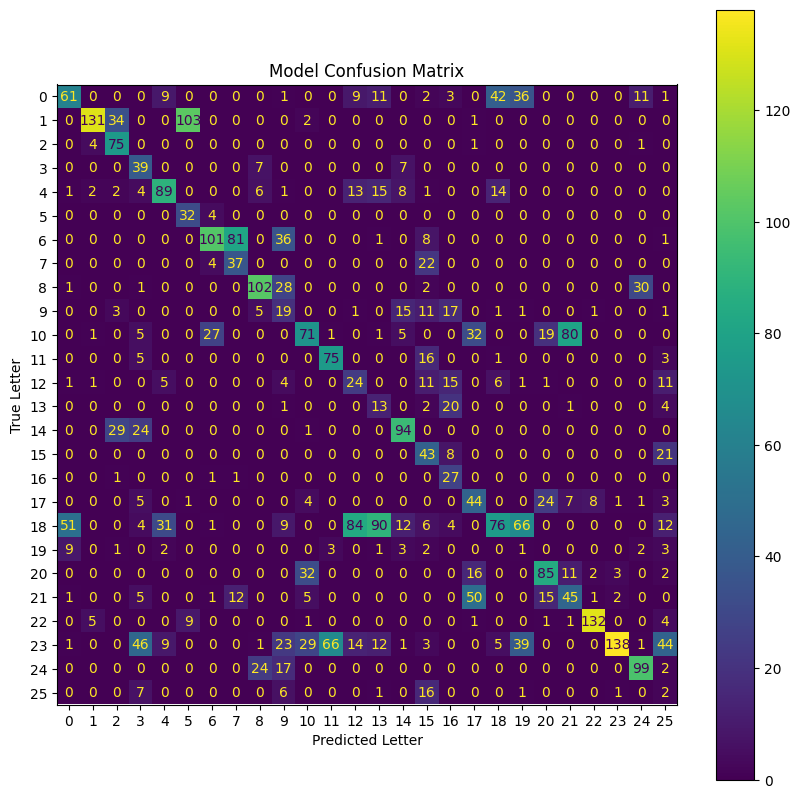

              precision    recall  f1-score   support

           A       0.48      0.33      0.39       186
           B       0.91      0.48      0.63       271
           C       0.52      0.93      0.66        81
           D       0.27      0.74      0.39        53
           E       0.61      0.57      0.59       156
           F       0.22      0.89      0.35        36
           G       0.73      0.44      0.55       228
           H       0.28      0.59      0.38        63
           I       0.70      0.62      0.66       164
           J       0.13      0.25      0.17        75
           K       0.49      0.29      0.37       242
           L       0.52      0.75      0.61       100
           M       0.17      0.30      0.21        80
           N       0.09      0.32      0.14        41
           O       0.65      0.64      0.64       148
           P       0.30      0.60      0.40        72
           Q       0.29      0.90      0.44        30
           R       0.30    

In [36]:
# evaluate KNN model using evaluation function
evaluate_model(letter_preds_knn, y_test)

In [38]:
#predict using normalized test data set & KNN model trainined on normalized data
y_preds_knn_norm = knn_norm.predict(X_test_norm) 
# convert numerical prediction into letter prediction
letter_preds_knn_norm = [y_train_dic[y_pred_knn_norm] for y_pred_knn_norm in y_preds_knn_norm]

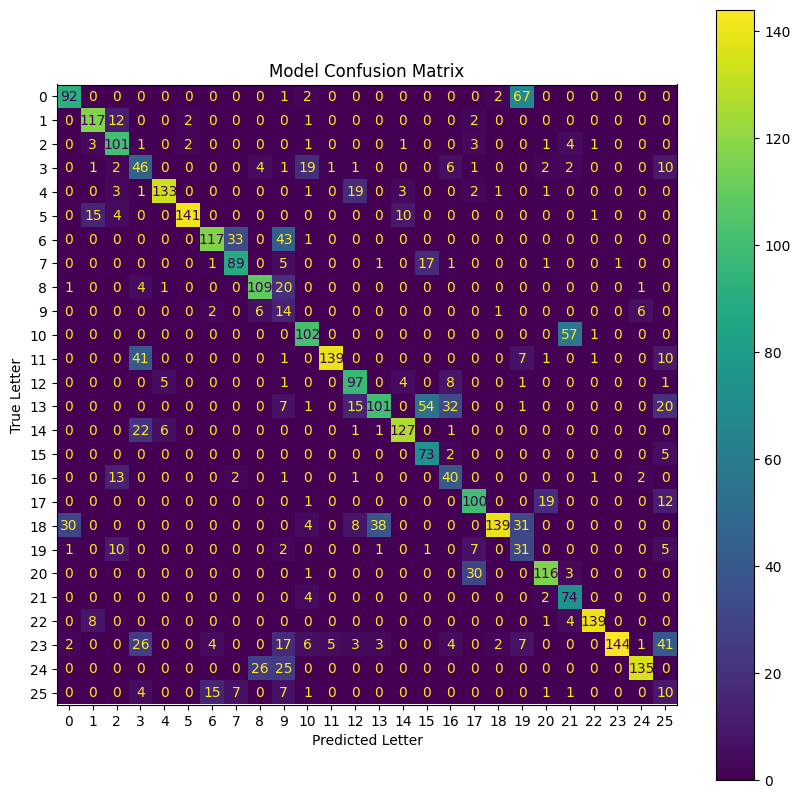

              precision    recall  f1-score   support

           A       0.73      0.56      0.63       164
           B       0.81      0.87      0.84       134
           C       0.70      0.86      0.77       118
           D       0.32      0.48      0.38        96
           E       0.92      0.81      0.86       164
           F       0.97      0.82      0.89       171
           G       0.84      0.60      0.70       194
           H       0.68      0.77      0.72       116
           I       0.75      0.80      0.78       136
           J       0.10      0.48      0.16        29
           K       0.70      0.64      0.67       160
           L       0.96      0.69      0.81       200
           M       0.67      0.83      0.74       117
           N       0.70      0.44      0.54       231
           O       0.88      0.80      0.84       158
           P       0.50      0.91      0.65        80
           Q       0.43      0.67      0.52        60
           R       0.69    

In [39]:
# evaluate KNN model using evaluation function
evaluate_model(letter_preds_knn_norm, y_test)

### CNN Model

In [40]:
# encode letters to numerical for target test set
y_test_cnn = pd.Categorical(y_test).codes

In [41]:
#predict using non-normalized test data set & CNN model trainined on non-normalized data
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = np.array([[round(b) for b in a] for a in y_pred_cnn])
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

114/114 [==============================] - 0s 2ms/step


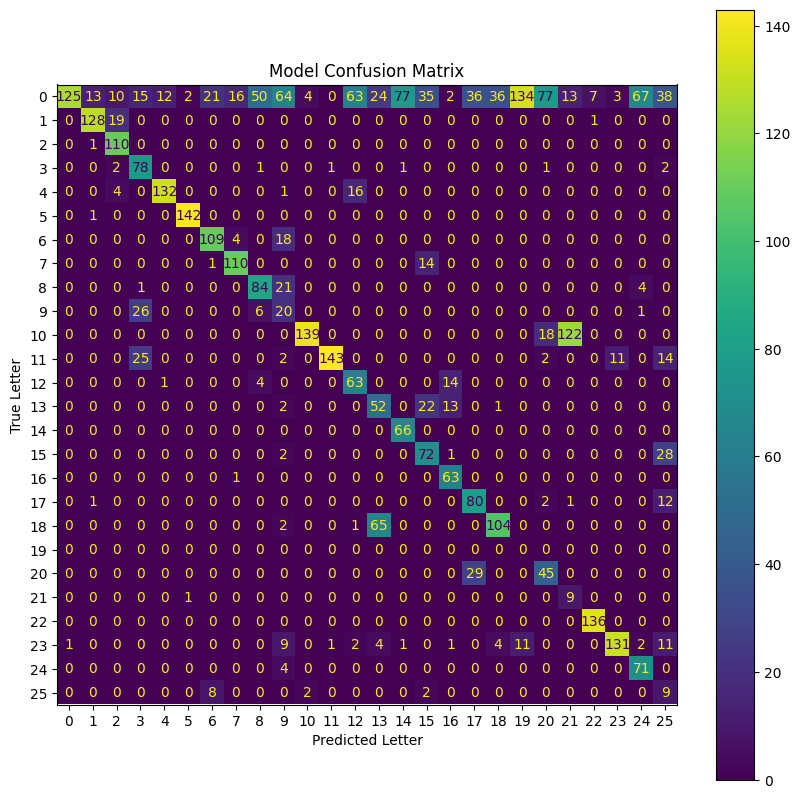

              precision    recall  f1-score   support

           0       0.99      0.13      0.23       944
           1       0.89      0.86      0.88       148
           2       0.76      0.99      0.86       111
           3       0.54      0.91      0.68        86
           4       0.91      0.86      0.89       153
           5       0.98      0.99      0.99       143
           6       0.78      0.83      0.81       131
           7       0.84      0.88      0.86       125
           8       0.58      0.76      0.66       110
           9       0.14      0.38      0.20        53
          10       0.96      0.50      0.66       279
          11       0.99      0.73      0.84       197
          12       0.43      0.77      0.56        82
          13       0.36      0.58      0.44        90
          14       0.46      1.00      0.63        66
          15       0.50      0.70      0.58       103
          16       0.67      0.98      0.80        64
          17       0.55    

/home/wendyto/.pyenv/versions/3.10.6/envs/sign-game-server/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wendyto/.pyenv/versions/3.10.6/envs/sign-game-server/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wendyto/.pyenv/versions/3.10.6/envs/sign-game-server/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

In [42]:
# evaluate CNN model using evaluation function
evaluate_model(y_pred_cnn, y_test_cnn)

In [43]:
#predict using normalized test data set & CNN model trainined on normalized data
y_pred_cnn_norm = model_cnn_norm.predict(X_test_norm_cnn)
y_pred_cnn_norm = np.array([[round(b) for b in a] for a in y_pred_cnn_norm])
y_pred_cnn_norm = np.argmax(y_pred_cnn_norm, axis=1)

114/114 [==============================] - 0s 2ms/step


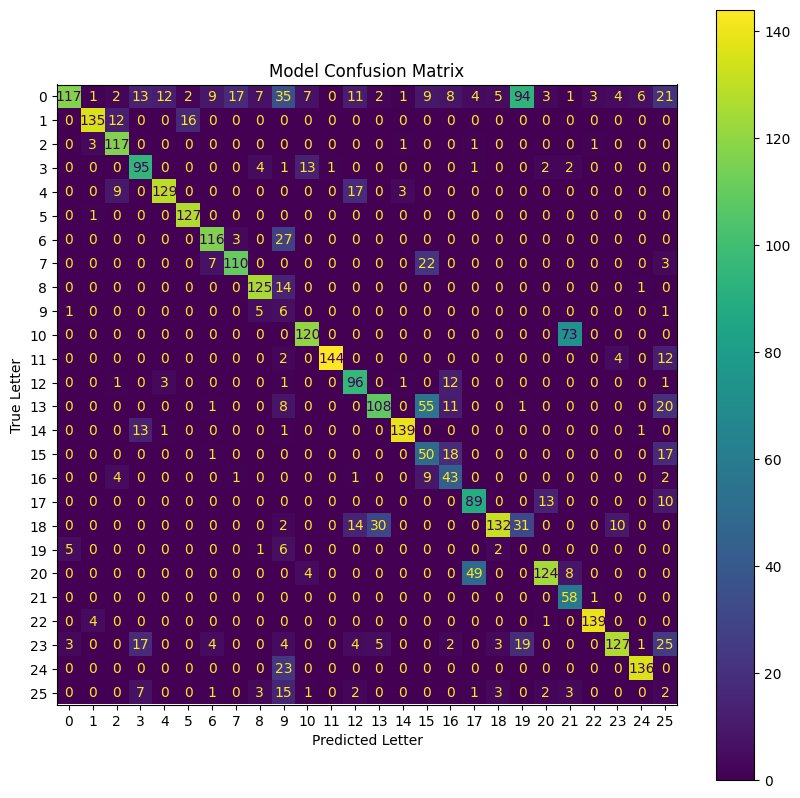

              precision    recall  f1-score   support

           0       0.93      0.30      0.45       394
           1       0.94      0.83      0.88       163
           2       0.81      0.95      0.87       123
           3       0.66      0.80      0.72       119
           4       0.89      0.82      0.85       158
           5       0.88      0.99      0.93       128
           6       0.83      0.79      0.81       146
           7       0.84      0.77      0.81       142
           8       0.86      0.89      0.88       140
           9       0.04      0.46      0.08        13
          10       0.83      0.62      0.71       193
          11       0.99      0.89      0.94       162
          12       0.66      0.83      0.74       115
          13       0.74      0.53      0.62       204
          14       0.96      0.90      0.93       155
          15       0.34      0.58      0.43        86
          16       0.46      0.72      0.56        60
          17       0.61    

In [44]:
# evaluate CNN model using evaluation function
evaluate_model(y_pred_cnn_norm, y_test_cnn)

### SVM Model

In [45]:
#predict using non-normalized test data set & model trainined on non-normalized data
y_preds_sgd = sgd.predict(X_test)
# convert numerical prediction into letter prediction
letter_preds_sgd = [y_train_dic[y_pred_sgd] for y_pred_sgd in y_preds_sgd]

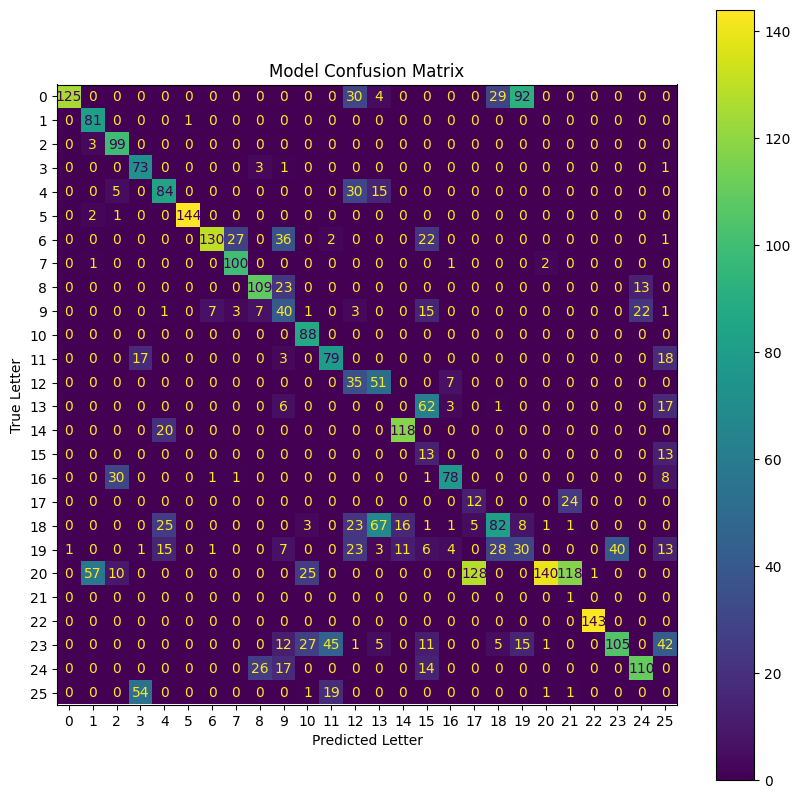

              precision    recall  f1-score   support

           A       0.99      0.45      0.62       280
           B       0.56      0.99      0.72        82
           C       0.68      0.97      0.80       102
           D       0.50      0.94      0.65        78
           E       0.58      0.63      0.60       134
           F       0.99      0.98      0.99       147
           G       0.94      0.60      0.73       218
           H       0.76      0.96      0.85       104
           I       0.75      0.75      0.75       145
           J       0.28      0.40      0.33       100
           K       0.61      1.00      0.76        88
           L       0.54      0.68      0.60       117
           M       0.24      0.38      0.29        93
           N       0.00      0.00      0.00        89
           O       0.81      0.86      0.83       138
           P       0.09      0.50      0.15        26
           Q       0.83      0.66      0.73       119
           R       0.08    

In [46]:
# evaluate SVM model using evaluation function
evaluate_model(letter_preds_sgd, y_test)

In [47]:
#predict using normalized test data set & model trainined on normalized data
y_preds_sgd_norm = sgd_norm.predict(X_test_norm)
letter_preds_sgd_norm = [y_train_dic[y_pred_sgd_norm] for y_pred_sgd_norm in y_preds_sgd_norm]

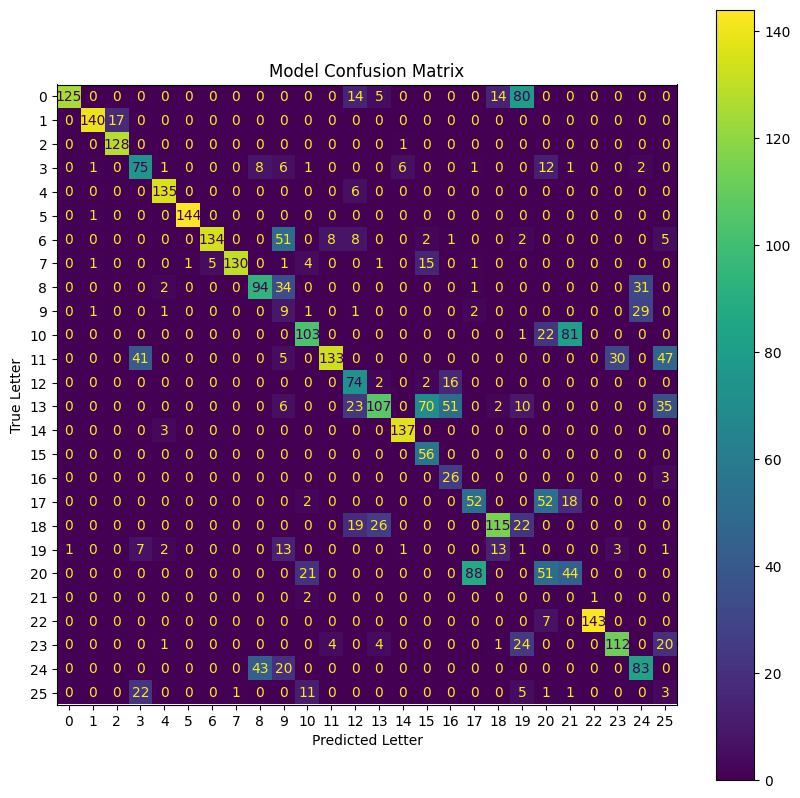

              precision    recall  f1-score   support

           A       0.99      0.53      0.69       238
           B       0.97      0.89      0.93       157
           C       0.88      0.99      0.93       129
           D       0.52      0.66      0.58       114
           E       0.93      0.96      0.94       141
           F       0.99      0.99      0.99       145
           G       0.96      0.64      0.77       211
           H       0.99      0.82      0.90       159
           I       0.65      0.58      0.61       162
           J       0.06      0.20      0.10        44
           K       0.71      0.50      0.59       207
           L       0.92      0.52      0.66       256
           M       0.51      0.79      0.62        94
           N       0.74      0.35      0.48       304
           O       0.94      0.98      0.96       140
           P       0.39      1.00      0.56        56
           Q       0.28      0.90      0.42        29
           R       0.36    

In [48]:
# evaluate SVM model using evaluation function
evaluate_model(letter_preds_sgd_norm, y_test)

### XGBoost

In [49]:
# dtest = xgb.DMatrix(X_test)
y_pred = np.argmax(model.predict(dtest), axis=1)

In [ ]:
# evaluate model using evaluation function
evaluate_model(y_test_enc, y_pred)